In [2]:
import pandas as pd

# The Palmer Archipelago Penguin Data

<img src="Images/cute_penguins.png" alt="Drawing" style="width: 500px;"/>

Art by @allison_horst

In [3]:
# load the data
url = 'https://raw.githubusercontent.com/um-perez-alvaro/Data-Science-Theory/master/Data/penguins_size.csv'
data = pd.read_csv(url)
data.head(5)

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.
This dataset contains data for 344 penguins.
There are 3 different species of penguins in this dataset, collected from 3 islands in the Palmer Archipelago, Antarctica.

In [4]:
data.species.value_counts()

Adelie       152
Gentoo       124
Chinstrap     68
Name: species, dtype: int64

The culmen is the upper ridge of a bird’s bill. For this penguin data, the culmen (bill) length and depth are measured as shown below.

<img src="Images/culmen_depth.png" alt="Drawing" style="width: 500px;"/>

The **goal** is to predict the penguin species from physical measurements (culmen length, culmen depth, flipper length, and body mass). 

**Part 1:** Import and instantiate a k-nearest neighbors model.

In [35]:
# your  code here
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

**Part 2:** Define the feature matrix X and the target vector y from the dataframe, and then split X and y into training and testing sets.

In [36]:
# your  code here
from sklearn.model_selection import train_test_split

X = data.drop(columns=['species'])
y = data.species

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Part 3:** Build a pipeline that consists of two steps: an imputer (to fill missing values with the mean value) and the knn classifier.

In [45]:
# your  code here
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# classification pipeline
numeric_features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
categorical_features = ['sex', 'island']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn_clf', knn_clf)
])

pipe_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['sex', 'island'])])),
                ('knn_clf', KNeighborsClassifier())])

**Part 4:** Use a grid search to tune in the `n_neighbors` and `weights` hyperparameters

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p>  The Palmer Archipelago Penguin Data is relatively small.
    Don't use a large value for the <tt> cv </tt> parameter</p> (Javier would use <tt> cv=5</tt>.)
</div>

In [46]:
# your  code here
from sklearn.model_selection import GridSearchCV

param_grid = {
    'knn_clf__n_neighbors': [3, 5, 7, 9, 11],
    'knn_clf__weights': ['uniform', 'distance'],
}

In [47]:
gridsearch = GridSearchCV(pipe_clf, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')

In [48]:
gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['culmen_length_mm',
                                                                          'culmen_depth_mm',
                                                                          'flipper_length_mm',
                                                                          'body_mass_g']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore')),
                                                                                         ('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['sex',
                                                                          'island'])])),
                                       ('knn_clf', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn_clf__n_neighbors': [3, 5, 7, 9, 11],
                         'knn_clf__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [49]:
gridsearch.best_params_

{'knn_clf__n_neighbors': 3, 'knn_clf__weights': 'distance'}

**Part 5:** Use accuracy and the confusion matrix to evaluate the performance of your best model on the test set

In [50]:
# your  code here
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

best_clf = gridsearch.best_estimator_

y_pred = best_clf.predict(X_test)

In [51]:
# accuracy
accuracy_score(y_test, y_pred)

0.7209302325581395

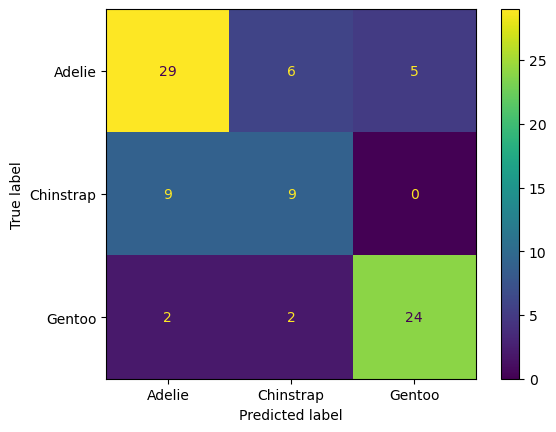

In [52]:
# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=['Adelie', 'Chinstrap', 'Gentoo'])

<div class="alert alert-block alert-danger"> <tt>KNeighborsClassifier </tt> is a distance based model. Distance based models are affected by the scale of the features. They give higher weightage to features which have higher magnitude (The <tt>body_mass_g</tt> feature in our case).
We do not want our classifier to be affected by the magnitude of the features. To overcome this problem, we can bring down all the variables to the same scale. </div>

**Part 6:** Add a `StandardScaler` to your pipeline, and repeat steps 4 and 5.

In [53]:
# your  code here
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipe_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn_clf', knn_clf)
])

pipe_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['culmen_length_mm',
                                                   'culmen_depth_mm',
                                                   'flipper_length_mm',
                                                   'body_mass_g']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('imputer',
                                                                   SimpleImputer())]),
                                                  ['sex', 'island'])])),
                ('knn_clf', KNeighborsClassifier())])

In [54]:
gridsearch = GridSearchCV(pipe_clf, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')

gridsearch.fit(X_train, y_train)

gridsearch.best_params_

best_clf = gridsearch.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


accuracy: 0.9883720930232558


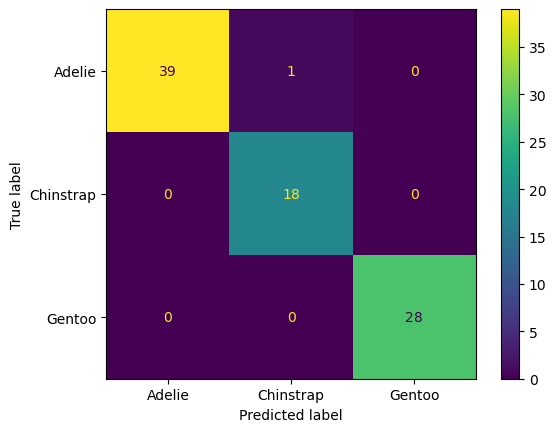

In [55]:
y_pred = best_clf.predict(X_test)

# accuracy
print('accuracy:', accuracy_score(y_test, y_pred))

# confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=['Adelie', 'Chinstrap', 'Gentoo'])